In [1]:
import pandas as pd
import threading
import random
import numpy as np
import seaborn as sns
from pprint import pprint
import subprocess
import os
from pyulog.core import ULog
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from utils.ULogHelper import *

In [2]:
meta_log_df = pd.read_json("./px4-Ulog-Parsers/MetaLogs.json")
quad_log = meta_log_df.loc[(meta_log_df.type == "Quadrotor") 
                           & (meta_log_df.hardware != "PX4_SITL") 
                           & (meta_log_df.errors == 0)]

quad_log["duration"] = pd.to_timedelta(quad_log['duration']).dt.total_seconds()
quad_log = quad_log[quad_log["duration"].between(1, 1000)]
len(quad_log)

/var/folders/98/l_64__1s7yl7t4kxht7j0bzw0000gn/T/ipykernel_36322/4124767383.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quad_log["duration"] = pd.to_timedelta(quad_log['duration']).dt.total_seconds()


20014

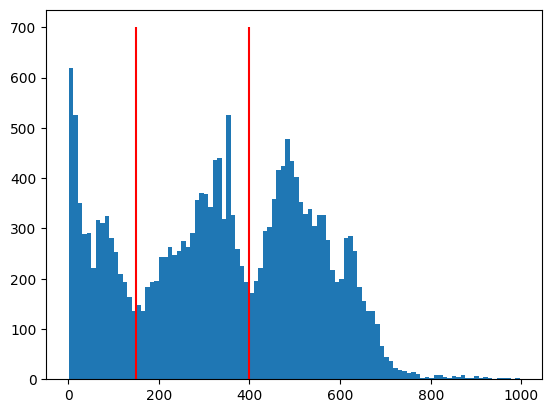

In [3]:
plt.hist(quad_log["duration"], bins=100)
plt.vlines(150, ymax=700, ymin=0, colors="r")
plt.vlines(400, ymax=700, ymin=0, colors="r")
plt.show()

In [4]:
def summaryPlot(df, nrows, ncols, cols_skip,min_count=0):
    
    col_names = [item for item in df.columns[3:] if item not in cols_skip]
    
    fig = plt.figure()
    
    for i, col_name in enumerate(col_names):
        
        if col_name in cols_skip:
            continue
        
        plt.subplot(nrows, ncols, i + 1)
        data_type = quad_log[col_name].dtypes
        
        if data_type == float or data_type == int:
            plt.hist(df[col_name], bins=30)
        else:
            tmp_df = df[col_name].value_counts()
            
            tmp_df = tmp_df[tmp_df > min_count]
            plt.plot(tmp_df.values)
        
        plt.title(col_name)
    plt.tight_layout()
    plt.show()
    

def getCount(dur_series, low, high):
    return len(dur_series[dur_series.between(low, high)])

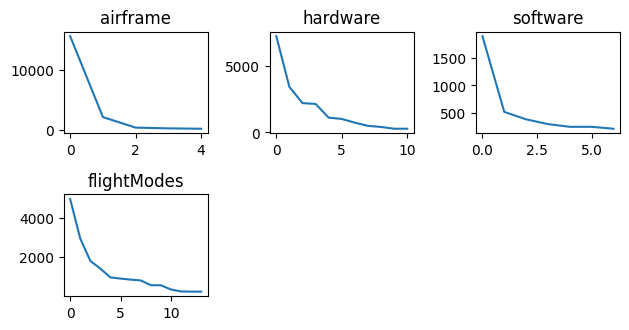

In [5]:
summaryPlot(quad_log, 3, 3, cols_skip=["duration", "startTime", "errors"], min_count=200)

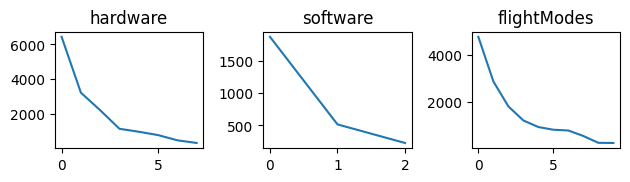

In [6]:
top_airframe = quad_log.airframe.value_counts().index[0]
quad_log = quad_log[quad_log["airframe"] == top_airframe]

summaryPlot(quad_log, 3, 3, min_count=200, cols_skip=["duration", "startTime", "errors", "airframe"])

In [7]:
print(getCount(quad_log["duration"], 150, 400))

6164


In [8]:
def getAutonomusUAVs(df):
    auto_uavs = []
    for index, modes in enumerate(quad_log.flightModes):

        if modes == "":
            continue

        lst_modes = modes.split(", ")
        if "Manual" not in lst_modes and "Mission" in lst_modes:
#         print(lst_modes, "Manual" in lst_modes, sep="-")
            auto_uavs.append(index)
        
    return df.iloc[auto_uavs]

In [9]:
quad_log = getAutonomusUAVs(quad_log)
print(getCount(quad_log["duration"], 150, 400))

4851


In [10]:
fligtModesCount = quad_log.flightModes.value_counts()[quad_log.flightModes.value_counts() > 500]

In [11]:
def jsonTopModes(topModes, in_df, n=None):
    df_lst = []
    
    for topMode in topModes:
        top_quad_modes = in_df[in_df.flightModes == topMode]
        if n != None and len(top_quad_modes) < n:
            continue
        
        if n != None:
            top_quad_modes = top_quad_modes.sample(n)
        
        df_lst.append(top_quad_modes)
    
    out_df = pd.concat(df_lst)
    print("Total ULG", len(pd.concat(df_lst)))
    
    quad_json = pd.DataFrame.to_json(out_df, 
                                     orient='records', 
                                     date_format="iso").replace("N\\/A", "N/A").replace("T00:00:00.000", "")
    return quad_json, out_df

In [12]:
quad_json, quad_files = jsonTopModes(fligtModesCount.index, 
                                     quad_log[quad_log.duration.between(150, 400)], 
                                     n=None)

Total ULG 4604


In [13]:
f = open("./QuadLogs_150-400Secs.json", "w")
f.write(quad_json)
f.close()

In [14]:
def extractLogData(file_path):
    log_data = ULog(file_path)
    data_dict = OrderedDict()
    log_data_list = log_data.data_list

    for d in log_data_list:
        data_items_list = [f.field_name for f in d.field_data]
        data_items_list.remove('timestamp')
        data_items_list.insert(0, 'timestamp')
        data_items = [(item, str(d.data[item].dtype), str(len(d.data[item]))) for item in data_items_list]

        i = 0
        name = d.name

        while True:
            if i > 0:
                name = d.name + '_' + str(i)
            if name in data_dict:
                i += 1
            else:
                break
        data_dict.setdefault(name, data_items[1:])
    return data_dict, log_data_list

def getCoords(data_dict, log_data_list):
        index = list(data_dict.keys()).index('vehicle_local_position')
        
        time_stamp_position = log_data_list[index].data['timestamp']/10**6
        z = log_data_list[index].data['z']
        x = log_data_list[index].data['x']
        y = log_data_list[index].data['y']
    
        return x, y, z
    
def getVelocity(data_dict, log_data_list):
    index = list(data_dict.keys()).index('vehicle_gps_position')
    return log_data_list[index].data["vel_m_s"].tolist()
    
def getWeatherDetails(data_dict, log_data_list):
    index = list(data_dict.keys()).index('vehicle_gps_position')
    
    return log_data_list[index]
    
def getCordCounts(x, y, pos):
    initIntX = int(x[0])
    initIntY = int(y[0])

    prevPos = [initIntX, initIntY]
    
    for i in range(len(x)):
        intX = int(x[i]) - initIntX
        if intX not in pos:
            pos[intX] = {}
            
        intY = int(y[i]) - initIntY
        diff = math.pow((intX - prevPos[0]),2) * math.pow((prevPos[1] - intY),2)
        if diff > 100000:
            continue
        pos[intX][intY] = pos[intX].get(intY, 0) + 1
        
        prevPos = [intX, intY]
    return pos

In [15]:
def showPosition(directory, flight_df, overwrite=False):
    subprocess.Popen('caffeinate')
    pos, coord_dict = {}, {}
    
    log_ids = flight_df.id
    pbar = tqdm(total=len(log_ids))
    
    for i, log_id in enumerate(log_ids):
  
        getULog(log_id, "./QuadLogs_200-400Secs.json", directory, overwrite=overwrite)
        file_path = os.path.join(directory, log_id + ".ulg")
    
        if i % 50 == 0:
            with open("./150-400_Coords.json", "w") as final:
                json.dump(coord_dict, final)


        if os.path.isfile(file_path) and "ulg" in file_path.split(".")[-1]:
            try:
                data_dict, log_data_list = extractLogData(file_path)
                index = list(data_dict.keys()).index('vehicle_local_position')
               
                x, y, z = getCoords(data_dict, log_data_list)
    
                coord_dict[log_id] = {"x":x.tolist(), 
                                      "y":y.tolist(), 
                                      "z":z.tolist(),
                                      "duration": flight_df.duration[flight_df.index[i]],
                                      "hardware": flight_df.hardware[flight_df.index[i]],
                                      "flight_mode": flight_df.flightModes[flight_df.index[i]],
                                      "software": flight_df.software[flight_df.index[i]],
                                      "velocity_ms": getVelocity(data_dict, log_data_list)
                                     }
                
                
                if(len(x) < 10):
                    continue
            
            except Exception as ex:
                print(ex)
                print("Failed to get position")
                
        removeULog(log_id, directory)
        clear_output()
        pbar.update(1)
        
    return coord_dict

In [16]:
# coord_dict = showPosition("test", quad_files, overwrite=True)
# with open("./150-400_Coords.json", "w") as final:
#     json.dump(coord_dict, final)

In [17]:
with open("./150-400_Coords.json", "r") as json_file:
    coord_dict = json.load(json_file)

In [18]:
from sklearn.decomposition import PCA
import numpy as np

coords_arr, dur_arr, hardware_arr, flight_mode_arr, software_arr = [], [], [], [], []
max_feat = -99999
labels=[]

i = 0
for key, coords in coord_dict.items():
    labels.append(key)

    dur_arr.append(coords["duration"])
    hardware_arr.append(coords["hardware"])
    flight_mode_arr.append(coords["flight_mode"])
    software_arr.append(coords["software"])
    
    xyz = coords["x"] + coords["y"] + coords["z"]
    
    max_feat = max(max_feat, len(xyz))
    
    
    coords_arr.append(xyz) 
    
    i += 1

In [19]:
col_names = [f"coord_{i}" for i in range(max_feat)]
df = pd.DataFrame(coords_arr, columns=col_names).fillna(0)
df["duration"] = dur_arr
df["hardware"] = pd.get_dummies(hardware_arr).values.argmax(1)
df["flight_mode"] = pd.get_dummies(flight_mode_arr).values.argmax(1)
df["software"] = pd.get_dummies(software_arr).values.argmax(1)

In [20]:
pca = PCA(n_components=3)
pca_test = pca.fit(df)

In [21]:
pca_test.explained_variance_ratio_

array([0.42612898, 0.14329776, 0.08068429])

In [22]:
pca_fit = pca.fit_transform(df)

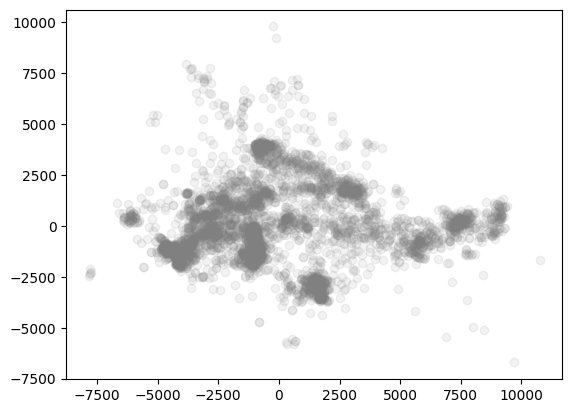

In [23]:
for i in range(len(labels)):

    x = pca_fit[i, 0]
    y = pca_fit[i, 1]
    plt.scatter(x, y, c="grey", alpha=0.1)
#     plt.annotate(str(i), # this is the text
#                  (x,y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

plt.show()

In [24]:
from sklearn.manifold import TSNE

In [25]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(df)

/Users/djlisko01/Desktop/Dunne_Lab/GitHub.nosync/Px4_Log_Analysis/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4603 samples in 1.969s...
[t-SNE] Computed neighbors for 4603 samples in 17.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4603
[t-SNE] Computed conditional probabilities for sample 2000 / 4603
[t-SNE] Computed conditional probabilities for sample 3000 / 4603
[t-SNE] Computed conditional probabilities for sample 4000 / 4603
[t-SNE] Computed conditional probabilities for sample 4603 / 4603
[t-SNE] Mean sigma: 949.482311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.791832
[t-SNE] KL divergence after 1000 iterations: 0.585002


In [26]:
import seaborn as sns
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne.index = labels

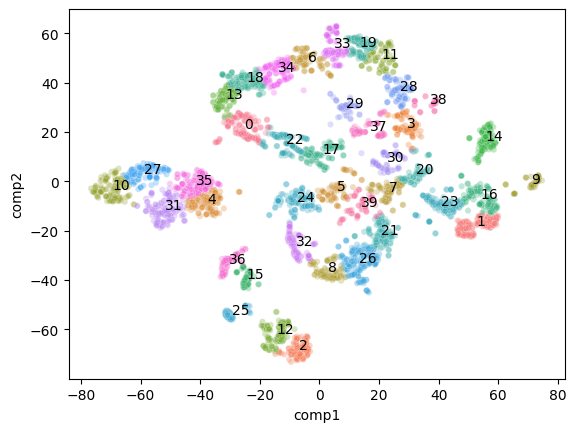

In [27]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 40)

#predict the labels of clusters.
df_tsne["clusters"] = kmeans.fit_predict(tsne_results)

# Calculate Centroids
centroids  = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=["x", "y"])

if df_tsne["clusters"].dtype.name != "category":
    df_tsne["clusters"] = df_tsne.clusters.astype("category")
    
df_tsne.sort_values(by="clusters", inplace=True)

ax = sns.scatterplot(x='comp1', y='comp2', data=df_tsne, hue="clusters", alpha=0.3, s=20)

for i in range(len(centroid_df.x)):
    x = centroid_df.x[i]
    y = centroid_df.y[i]
    c_lbl = centroid_df.index[i]
    ax.text(x, y, str(c_lbl))
plt.legend([],[], frameon=False)
# sns.scatterplot(x='x', y='y', data=centroid_df, marker="*", color="black", s=100)

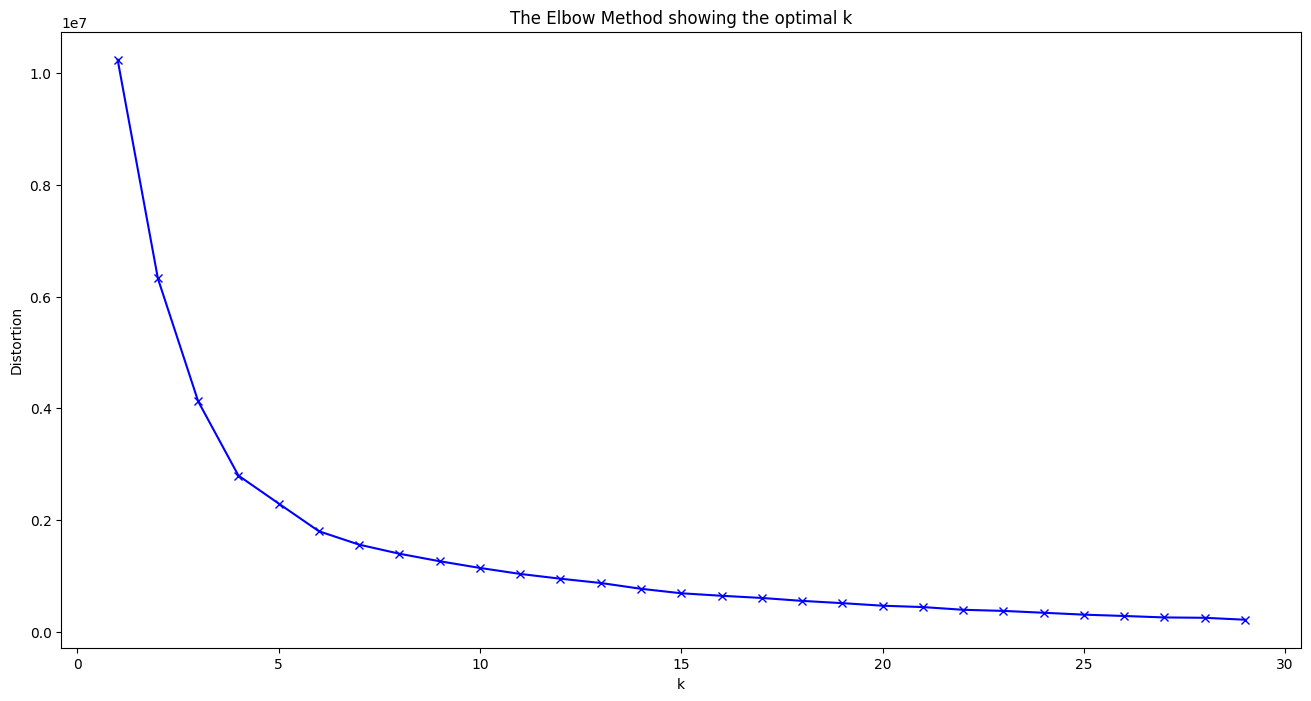

In [28]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_tsne)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
import math
def calculateSSE(df, centroid_pts):

    total_dist = 0
    for i in range(len(df)):
        pt1 = df.iloc[i,:2].values
        pt2 = centroid_pts.values
    
        total_dist += math.dist(pt1 ,pt2)
    
    return math.sqrt(total_dist)

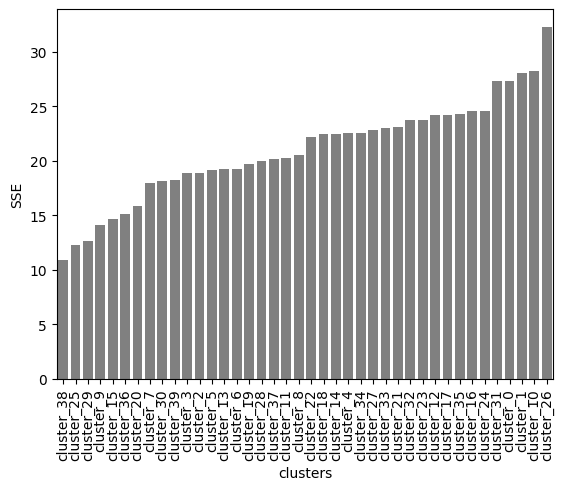

In [30]:
clstr_sse = {}
for i in range(len(centroid_df)):
    
    subset_pts = df_tsne[df_tsne.clusters == i]
    sse = calculateSSE(subset_pts, centroid_pts=centroid_df.iloc[i])
    
    clstr_sse[i] = {}
    clstr_sse[i]["SSE"] = sse
    clstr_sse[i]["pts"] = len(subset_pts)

sse_df = pd.DataFrame.from_dict(clstr_sse).T
sse_df["clusters"] = [f"cluster_{i}" for i in sse_df.index]
sse_df.rename(columns={sse_df.columns[0]:"SSE"}, inplace=True)

sns.barplot(x="clusters", y="SSE", data=sse_df, order=sse_df.sort_values('SSE').clusters, color="gray")
plt.xticks(rotation=90)
plt.show()

In [31]:
from IPython.core.display import HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: unset;
}
</style>
"""
HTML(style) 

In [32]:
def plotCoords(sse_df):
    
    n = len(sse_df)
    fig = plt.figure(figsize=(20, 50), dpi=40)
    int_seen = set()
    
    random_coords = {}
    
    pos = 1
    
    for i in range(n):
        cluster_num = int(sse_df.iloc[i].clusters.split("_")[1])
        
        random_coords[cluster_num] = []

        for j in range(5):

            plt.subplot(n, 5, pos)
            rnd_int = random.randint(0, len(df_tsne[df_tsne.clusters == cluster_num].index) - 1)

            while rnd_int in int_seen:
                  rnd_int = random.randint(0, len(df_tsne[df_tsne.clusters == cluster_num].index) - 1)

            random_coords[cluster_num].append(rnd_int)
            int_seen.add(rnd_int)


            toPlot = df_tsne[df_tsne.clusters == cluster_num].index[rnd_int]
            test_coords = coord_dict[toPlot]
            plt.xticks([])
            plt.yticks([])

            if pos % 5 == 1:
                plt.ylabel(f"cluster_{cluster_num}", fontsize=15)

            plt.title(rnd_int, fontsize=20)
            plt.scatter(test_coords["x"], test_coords["y"], s=2)

            pos += 1
    plt.tight_layout()
    plt.show()
    return random_coords

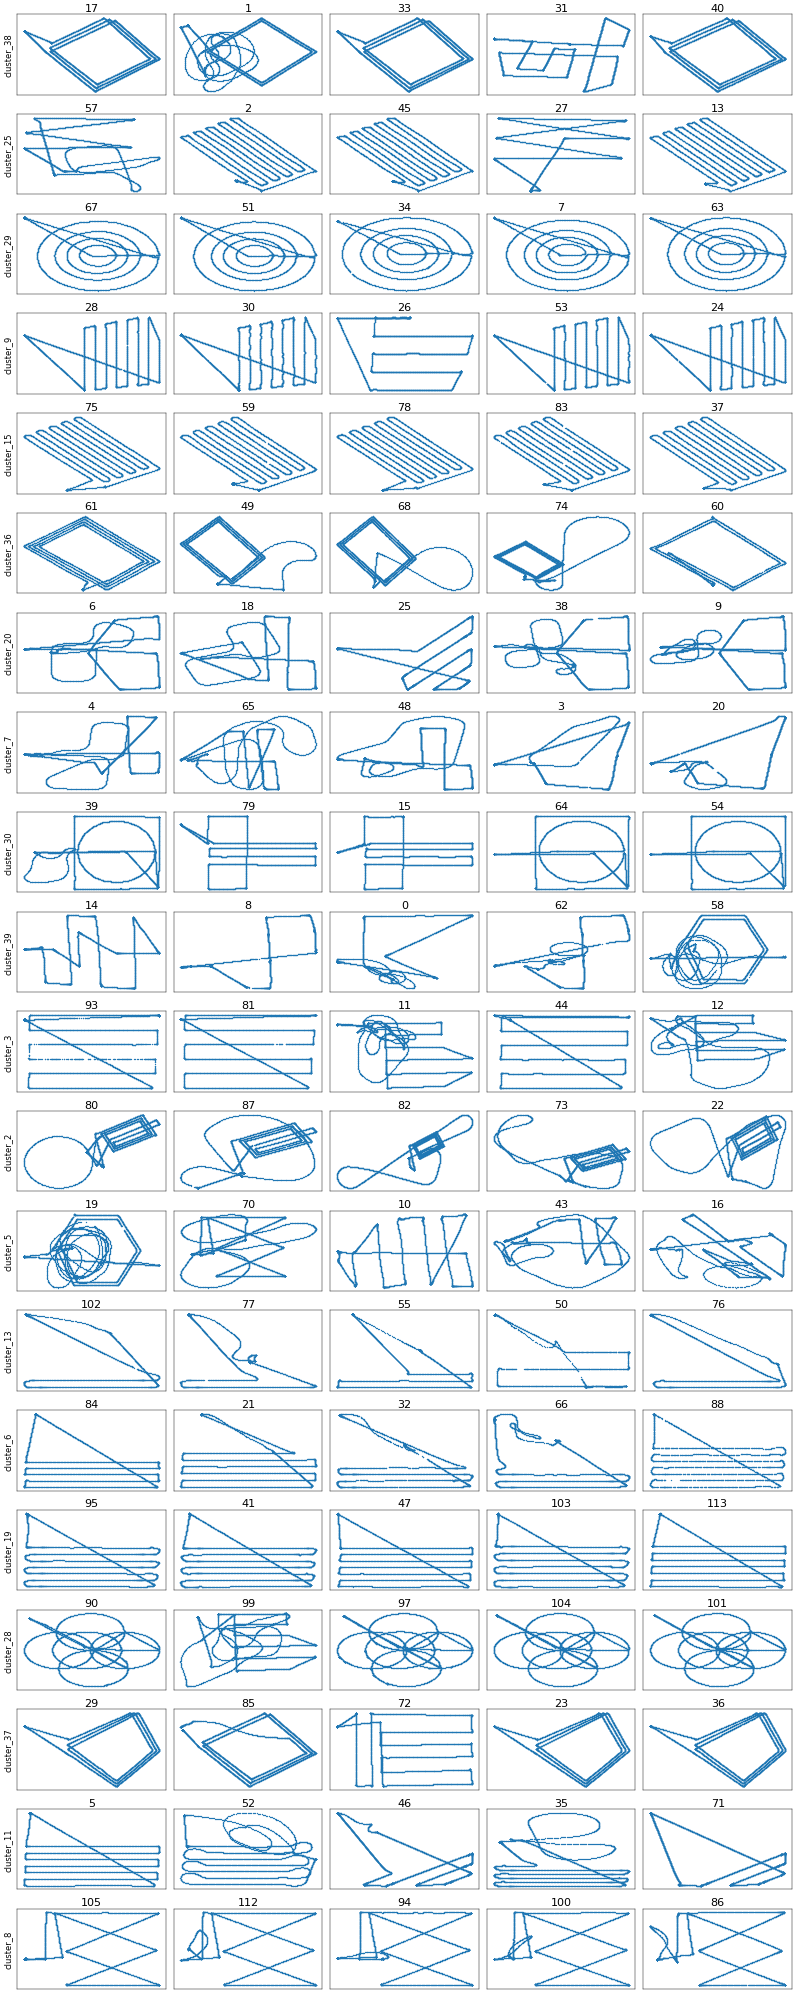

In [33]:
sse_df.sort_values(by="SSE", inplace=True)
random_coords = plotCoords(sse_df[:20])

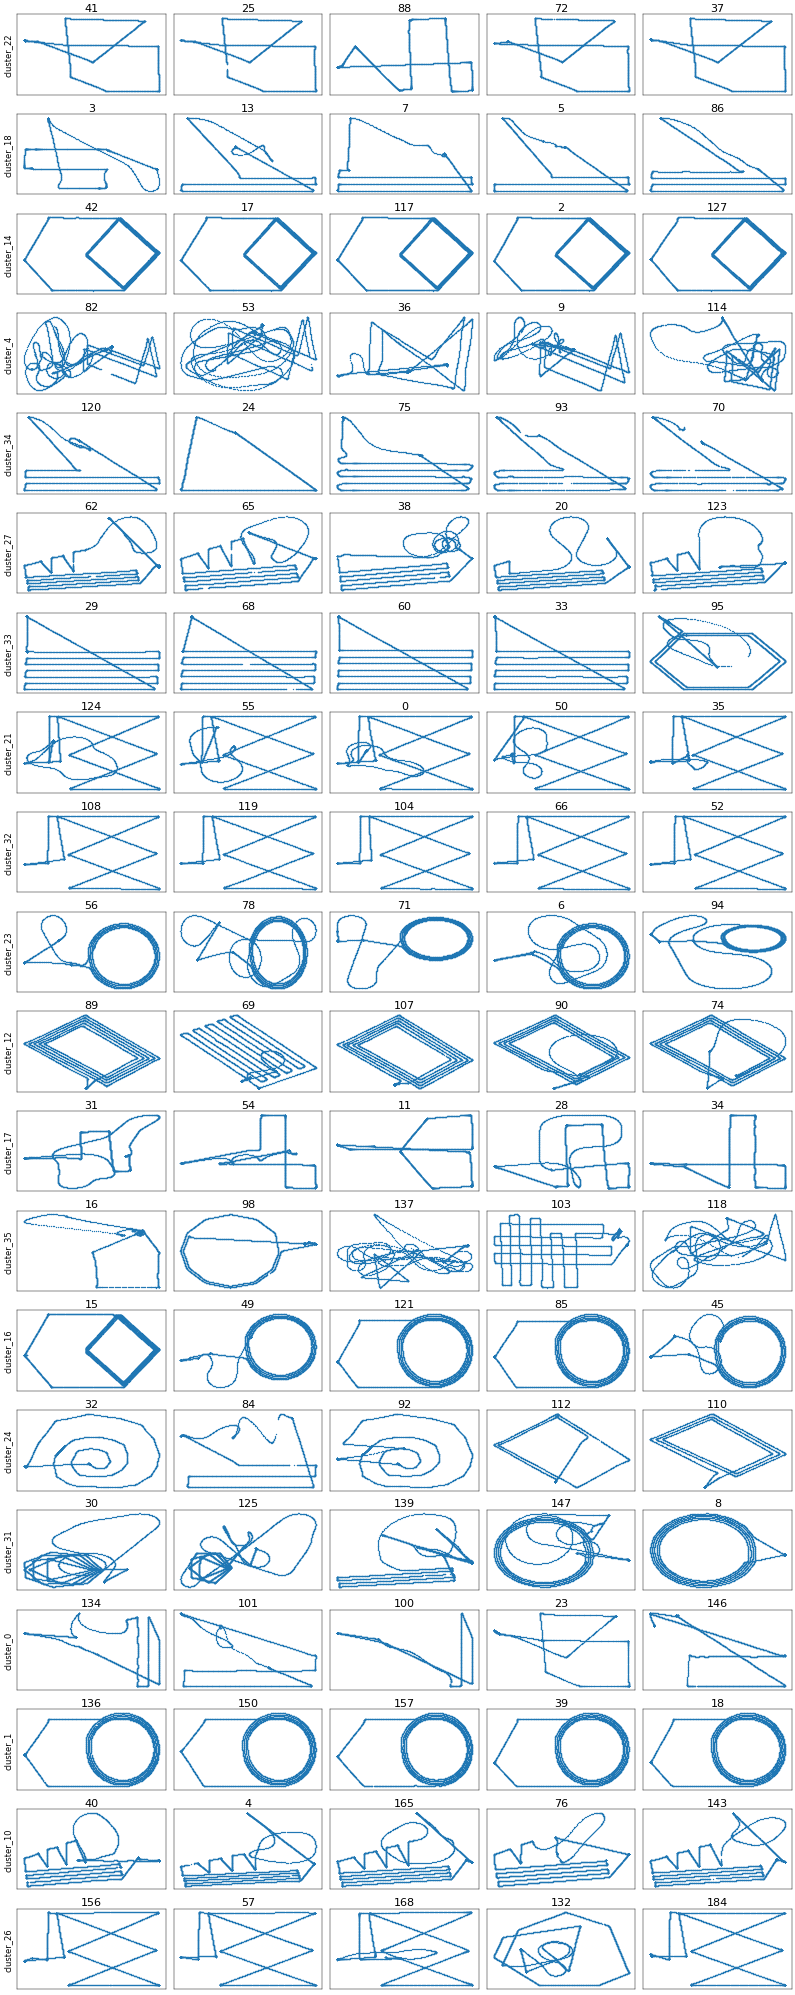

In [34]:
random_coords.update(plotCoords(sse_df[20:]))